In [69]:
import pandas as pd
import numpy as np
import pickle
import calendar
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Data Cleaning

In [70]:
data = None
data = pd.read_csv('fortcollinsdaily.csv')

# Drop station column
data = data.drop('STATION', axis=1)

# Convert date to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# lowercase all column names
data.columns = map(str.lower, data.columns)

# rename cols to match boulder data
data = data.rename(columns={'snwd': 'snowcover'})
data = data.rename(columns={'prcp': 'precip'})

data.head()

,date,precip,snow,snowcover,tmax,tmin
0,1948-08-01,0.00,0.0,NaN,82.0,51.0
1,1948-08-02,0.00,0.0,NaN,84.0,50.0
2,1948-08-03,0.00,0.0,NaN,77.0,54.0
3,1948-08-04,0.09,0.0,NaN,73.0,56.0
4,1948-08-05,0.50,0.0,NaN,78.0,59.0


In [71]:
# Drop remaining rows with missing values if needed
data = data.dropna()

# Save the cleaned data
data.to_csv('fortcollinsdaily_cleaned.csv', index=False)
data.head()

,date,precip,snow,snowcover,tmax,tmin
153,1949-01-01,0.00,0.0,0.0,29.0,20.0
154,1949-01-02,0.00,0.0,3.0,49.0,11.0
155,1949-01-03,0.05,4.0,7.0,23.0,3.0
156,1949-01-04,0.05,2.0,7.0,16.0,2.0
157,1949-01-05,0.00,0.0,7.0,27.0,14.0


In [72]:
#Check for missing values
data.isnull().sum()

date         0
precip       0
snow         0
snowcover    0
tmax         0
tmin         0
dtype: int64

## Plots

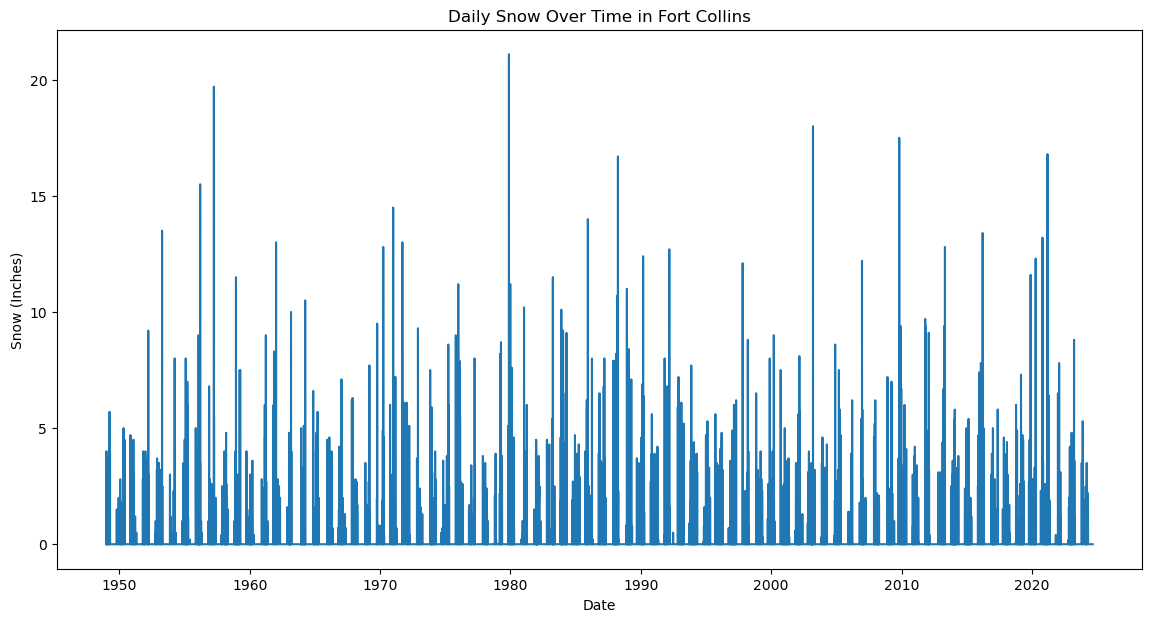

In [73]:
# Set default figure size
plt.rc('figure', figsize = (14, 7))

plt.plot(data['date'], data['snow'], label='Snow')
plt.title('Daily Snow Over Time in Fort Collins')
plt.xlabel('Date')
plt.ylabel('Snow (Inches)')

plt.show()

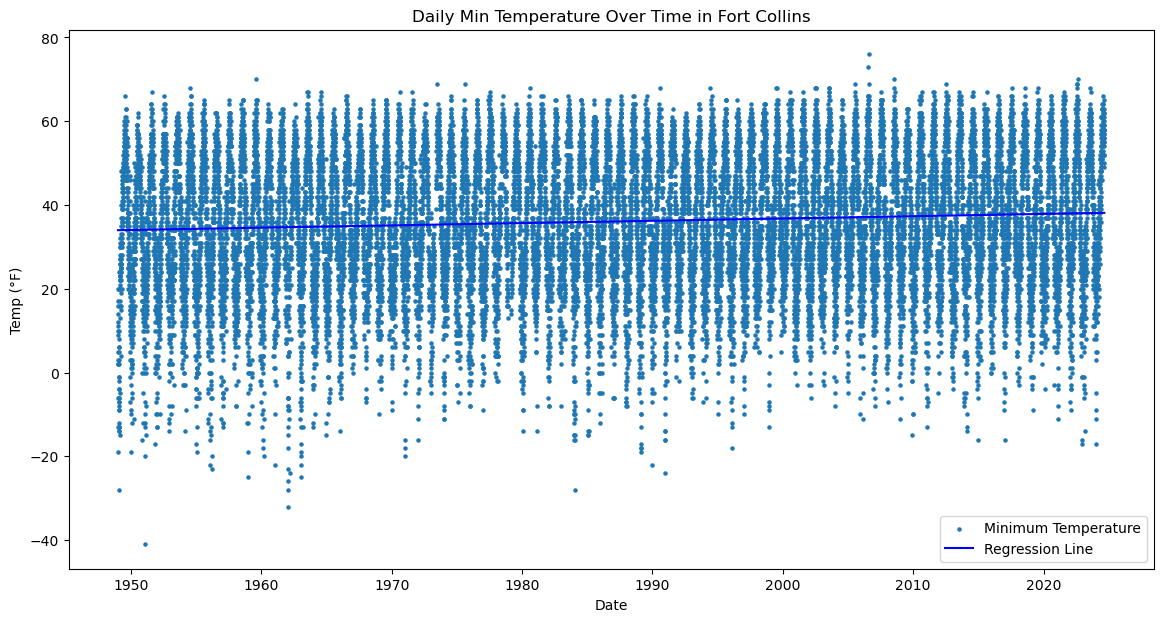

Slope: 0.00015004 degrees/year
R-squared: 0.00526949
P-value: 0.0000000000
Standard Error: 0.00001254 degrees/year


In [74]:
# Scatter plot
plt.scatter(data['date'], data['tmin'], label='Minimum Temperature', s=5)
plt.title('Daily Min Temperature Over Time in Fort Collins')
plt.xlabel('Date')
plt.ylabel('Temp (°F)')

# Perform linear regression on the filtered data using date ordinal values
ordinal_dates = data['date'].map(pd.Timestamp.toordinal)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    ordinal_dates,
    data['tmin']
)

# Create regression line values
regression_line = intercept + slope * ordinal_dates

# Plot the regression line
plt.plot(
    data['date'],
    regression_line,
    color='blue',
    label='Regression Line'
)

# Add legend and show plot
plt.legend()
plt.savefig('plots/fortcollins/daily_min_temp_regression.png', bbox_inches='tight')
plt.show()


# Print regression statistics
print(f"Slope: {slope:.8f} degrees/year")
print(f"R-squared: {r_value**2:.8f}")
print(f"P-value: {p_value:.10f}")
print(f"Standard Error: {std_err:.8f} degrees/year")

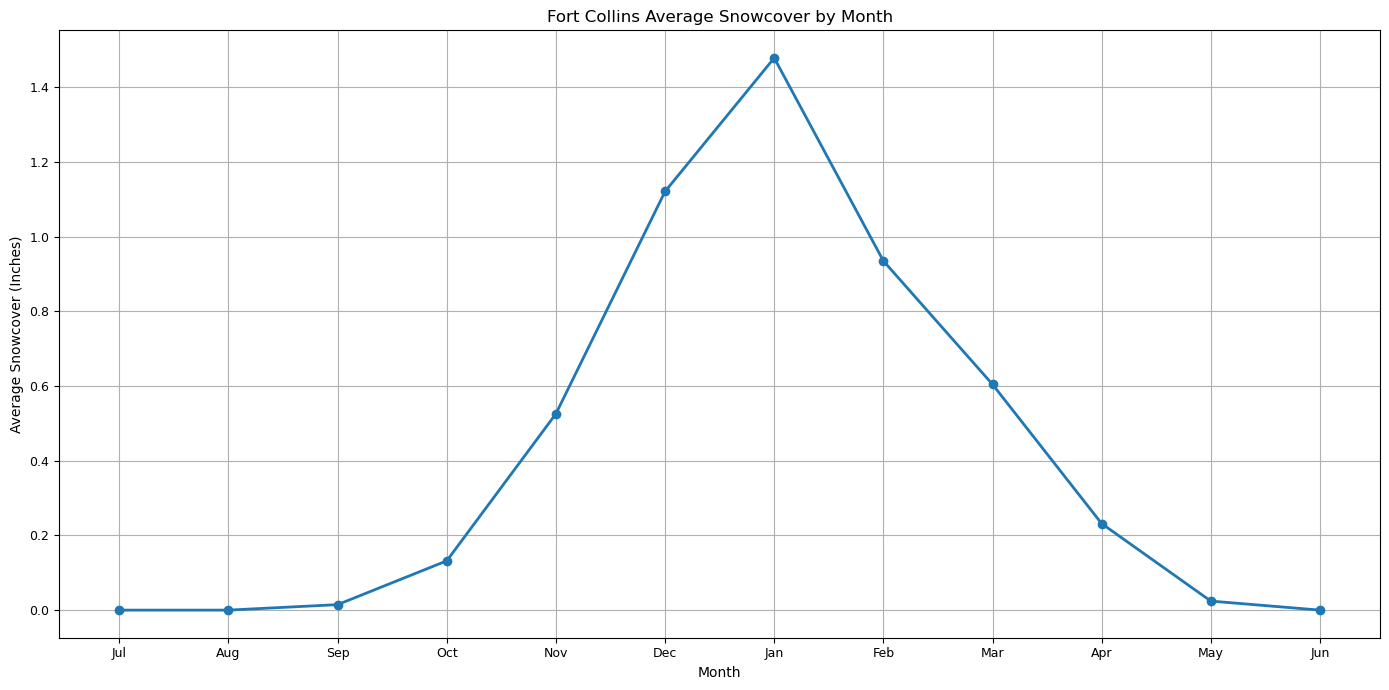

In [75]:
# Create a dictionary to map months starting in July
month_map = {((m - 7) % 12 + 1): calendar.month_abbr[m] for m in range(1, 13)}

# Group by new month order for average snowcover
monthly_snowcover = data.groupby((data['date'].dt.month - 7) % 12 + 1)['snowcover'].mean()

# Plotting
#plt.figure(figsize=(6, 4))
plt.plot(monthly_snowcover.index, monthly_snowcover.values, marker='o', markersize=6, linewidth=2)

plt.title('Fort Collins Average Snowcover by Month', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Average Snowcover (Inches)', fontsize=10)

# Adjusting x-axis to show months starting from July using the dictionary
month_labels = [month_map[m] for m in monthly_snowcover.index]
plt.xticks(monthly_snowcover.index, labels=month_labels, fontsize=9)
plt.yticks(fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

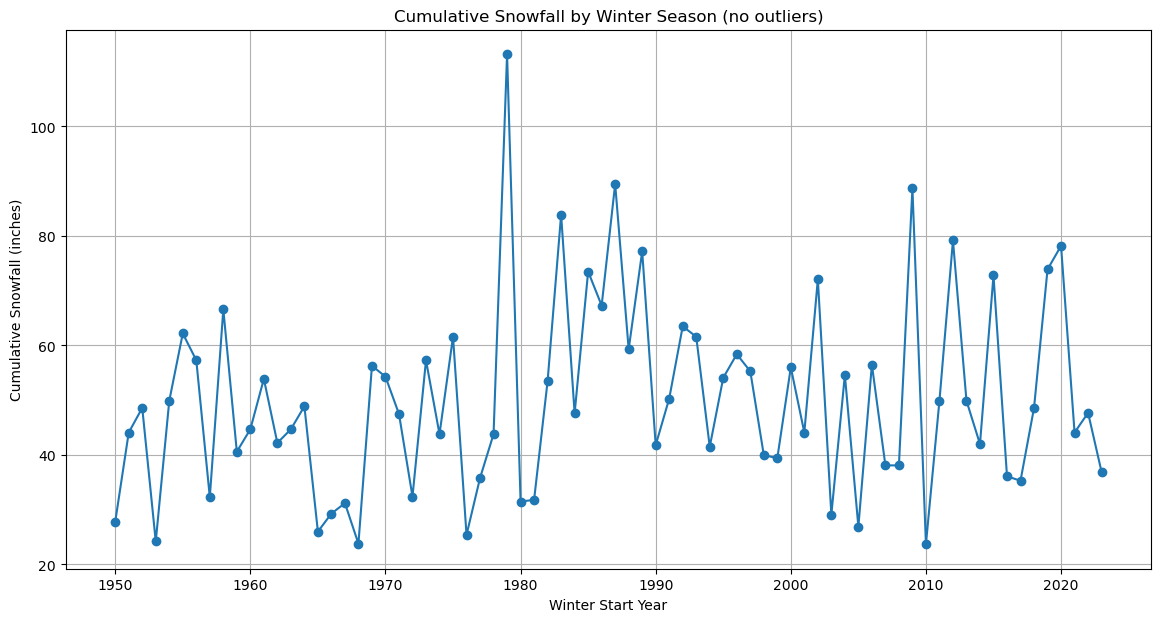

In [76]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Define winter season as starting from September to June of the following year
winter_season_snowfall = []

for start_year in range(1950, 2024):
    winter_season_start = f"{start_year}-09-01"
    winter_season_end = f"{start_year + 1}-05-31"
    
    # Filter the data for just the winter season
    season_data = data[(data['date'] >= winter_season_start) & (data['date'] <= winter_season_end)]
    
    # Cumulative sum
    cumulative_snow = season_data['snow'].sum()
    winter_season_snowfall.append({'winter_start_year': start_year, 'cumulative_snowfall': cumulative_snow})

# Convert to DataFrame
winter_season_df = pd.DataFrame(winter_season_snowfall)

# Remove outliers using IQR
Q1 = winter_season_df['cumulative_snowfall'].quantile(0.25)
Q3 = winter_season_df['cumulative_snowfall'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
winter_season_temp_df = winter_season_df[
    (winter_season_df['cumulative_snowfall'] >= lower_bound) &
    (winter_season_df['cumulative_snowfall'] <= upper_bound)
]

# Plot
#plt.figure(figsize=(12, 6))
plt.plot(
    winter_season_df['winter_start_year'],
    winter_season_df['cumulative_snowfall'],
    marker='o'
)
plt.title("Cumulative Snowfall by Winter Season (no outliers)")
plt.xlabel("Winter Start Year")
plt.ylabel("Cumulative Snowfall (inches)")
plt.grid(True)
plt.savefig('plots/fortcollins/cumulative_snowfall.png', bbox_inches='tight')
plt.show()

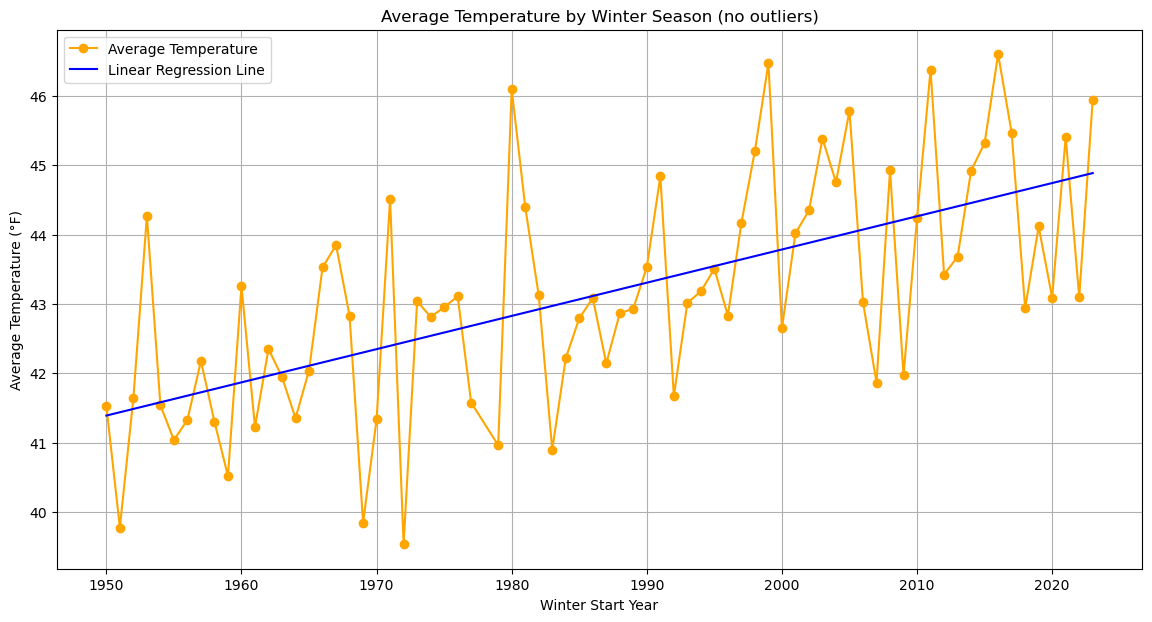

Slope: 0.0001311606 degrees/year
R-squared: 0.3862631517
P-value: 0.0000000044
Standard Error: 0.0000196211 degrees/year


In [77]:
# Average temperature for each winter season from 1950 to 2023
winter_season_temp = []

for start_year in range(1950, 2024):
    winter_season_start = f"{start_year}-09-01"
    winter_season_end = f"{start_year + 1}-05-31"
    
    season_data = data[(data['date'] >= winter_season_start) & (data['date'] <= winter_season_end)]
    
    # Average temperature for the season (using the mean of daily average temperatures)
    season_avg_temp = (season_data['tmax'] + season_data['tmin']).mean() / 2
    winter_season_temp.append({'winter_start_year': start_year, 'average_temp': season_avg_temp})



# Convert to DataFrame
winter_season_temp_df = pd.DataFrame(winter_season_temp)

# Remove outliers using IQR
Q1 = winter_season_temp_df['average_temp'].quantile(0.25)
Q3 = winter_season_temp_df['average_temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
winter_season_temp_df = winter_season_temp_df[
    (winter_season_temp_df['average_temp'] >= lower_bound) &
    (winter_season_temp_df['average_temp'] <= upper_bound)
]

# Convert winter start year to ordinal for regression
winter_season_temp_df['winter_ordinal'] = pd.to_datetime(winter_season_temp_df['winter_start_year'], format='%Y').map(pd.Timestamp.toordinal)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    winter_season_temp_df['winter_ordinal'], winter_season_temp_df['average_temp']
)

# Regression line
regression_line = intercept + slope * winter_season_temp_df['winter_ordinal']

# Plot the average temperature trends over the winter seasons with regression line
#plt.figure(figsize=(12, 6))
plt.plot(
    winter_season_temp_df['winter_start_year'],
    winter_season_temp_df['average_temp'],
    marker='o',
    color='orange',
    label='Average Temperature'
)
plt.plot(
    winter_season_temp_df['winter_start_year'],
    regression_line,
    color='blue',
    label='Linear Regression Line'
)
plt.title("Average Temperature by Winter Season (no outliers)")
plt.xlabel("Winter Start Year")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.savefig('plots/fortcollins/avg_temp_by_season.png', bbox_inches='tight')
plt.show()

# Print regression statistics
print(f"Slope: {slope:.10f} degrees/year")
print(f"R-squared: {r_value**2:.10f}")
print(f"P-value: {p_value:.10f}")
print(f"Standard Error: {std_err:.10f} degrees/year")


In [78]:
# Copy dataframe
data_with_avg = data.copy()

# Calculate the average temperature for each day
data_with_avg['average_temp'] = (data_with_avg['tmax'] + data_with_avg['tmin']) / 2
data_with_avg['year'] = data_with_avg['date'].dt.year
data_with_avg['month'] = data_with_avg['date'].dt.month

# Create 'month_start' as the first day of each month
data_with_avg['month_start'] = data_with_avg['date'].dt.to_period('M').dt.to_timestamp()

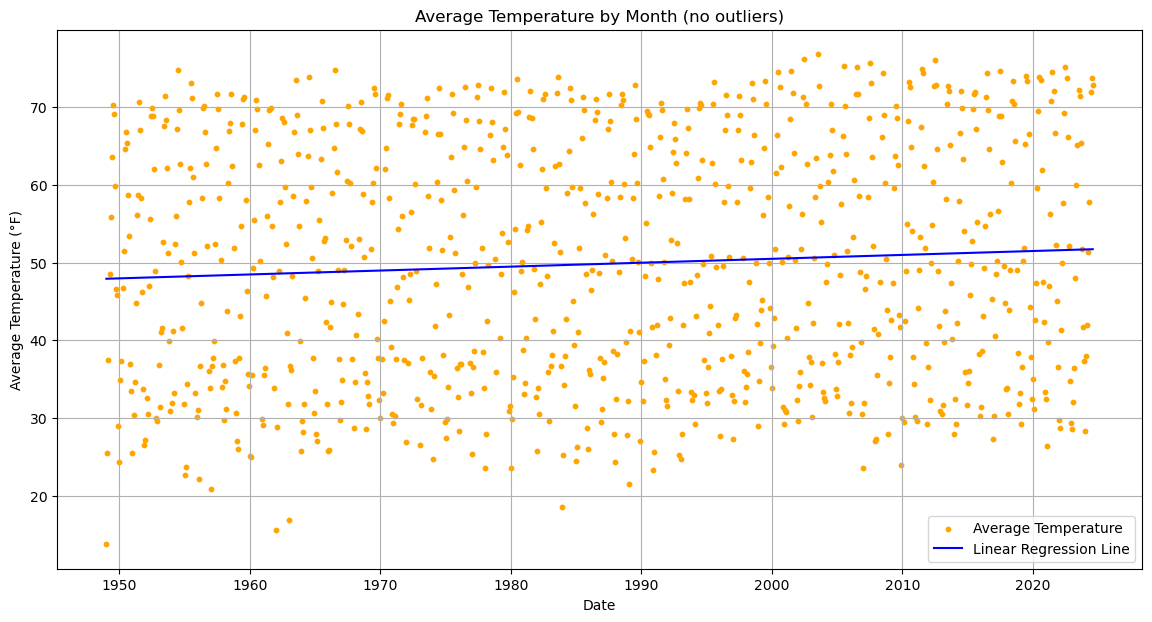

Slope: 0.00013742 days/year
R-squared: 0.00514376
P-value: 0.03201858
Standard Error: 0.00006399 days/year


In [79]:
# Get the average temperature for each month
monthly_avg_temp = data_with_avg.groupby('month_start')['average_temp'].mean().reset_index()

# Remove outliers using IQR
Q1 = monthly_avg_temp['average_temp'].quantile(0.25)
Q3 = monthly_avg_temp['average_temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_monthly_avg_temp = monthly_avg_temp[
    (monthly_avg_temp['average_temp'] >= lower_bound) &
    (monthly_avg_temp['average_temp'] <= upper_bound)
]


# Ordinal values for regression
filtered_monthly_avg_temp['month_ordinal'] = filtered_monthly_avg_temp['month_start'].map(pd.Timestamp.toordinal)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_monthly_avg_temp['month_ordinal'], filtered_monthly_avg_temp['average_temp']
)

regression_line = intercept + slope * filtered_monthly_avg_temp['month_ordinal']

# Plot the average temperature trends over the months
#plt.figure(figsize=(15, 7))
plt.scatter(
  filtered_monthly_avg_temp['month_start'],
  filtered_monthly_avg_temp['average_temp'],
  color='orange',
  label='Average Temperature',
  s=10
)
plt.plot(
  filtered_monthly_avg_temp['month_start'],
  regression_line,
  color='blue',
  label='Linear Regression Line'
)
plt.title("Average Temperature by Month (no outliers)")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.savefig('plots/fortcollins/avg_temp_by_month.png', bbox_inches='tight')
plt.show()

print(f"Slope: {slope:.8f} days/year")
print(f"R-squared: {r_value**2:.8f}")
print(f"P-value: {p_value:.8f}")
print(f"Standard Error: {std_err:.8f} days/year")


P-value is very very high, so we can't reject the null hypothesis. With standard error so high the true slope could be positive, the linear regression line is not reliable at all.

/var/folders/fj/b7m96gv142sb26tzg9qm1vw80000gn/T/ipykernel_92720/21222118.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_monthly_avg_temp['month_ordinal'] = filtered_monthly_avg_temp['month_start'].map(pd.Timestamp.toordinal)


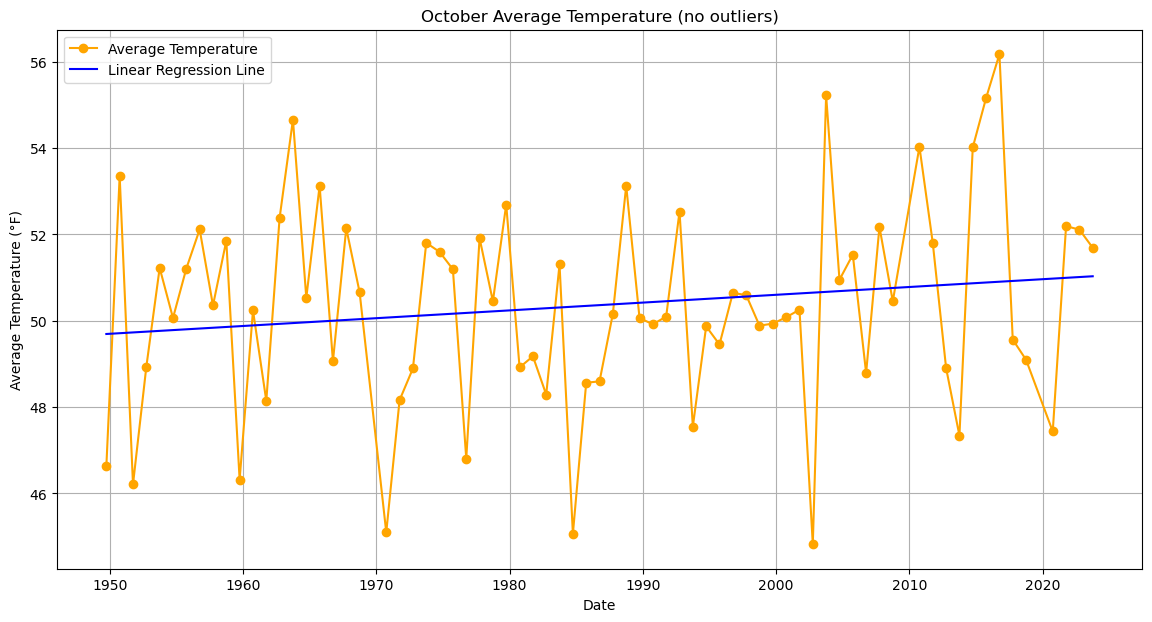

Slope: 0.00004949 days/year
R-squared: 0.02658115
P-value: 0.17119301
Standard Error: 0.00003580 days/year


In [80]:
months_to_include = [10]
filtered_data = data_with_avg[data_with_avg['month'].isin(months_to_include)]

# Calculate the average temperature for each month
monthly_avg_temp = filtered_data.groupby('month_start')['average_temp'].mean().reset_index()

# Remove outliers using IQR
Q1 = monthly_avg_temp['average_temp'].quantile(0.25)
Q3 = monthly_avg_temp['average_temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_monthly_avg_temp = monthly_avg_temp[
    (monthly_avg_temp['average_temp'] >= lower_bound) &
    (monthly_avg_temp['average_temp'] <= upper_bound)
]

# Linear regression on the filtered data
filtered_monthly_avg_temp['month_ordinal'] = filtered_monthly_avg_temp['month_start'].map(pd.Timestamp.toordinal)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_monthly_avg_temp['month_ordinal'], filtered_monthly_avg_temp['average_temp']
)

regression_line = intercept + slope * filtered_monthly_avg_temp['month_ordinal']

# Plot
#plt.figure(figsize=(15, 7))
plt.plot(
  filtered_monthly_avg_temp['month_start'],
  filtered_monthly_avg_temp['average_temp'],
  color='orange',
  marker='o',
  label='Average Temperature'
)
plt.plot(
  filtered_monthly_avg_temp['month_start'],
  regression_line,
  color='blue',
  label='Linear Regression Line'
)
plt.title(f"October Average Temperature (no outliers)")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.savefig('plots/fortcollins/october_temp.png', bbox_inches='tight')
plt.show()

print(f"Slope: {slope:.8f} days/year")
print(f"R-squared: {r_value**2:.8f}")
print(f"P-value: {p_value:.8f}")
print(f"Standard Error: {std_err:.8f} days/year")


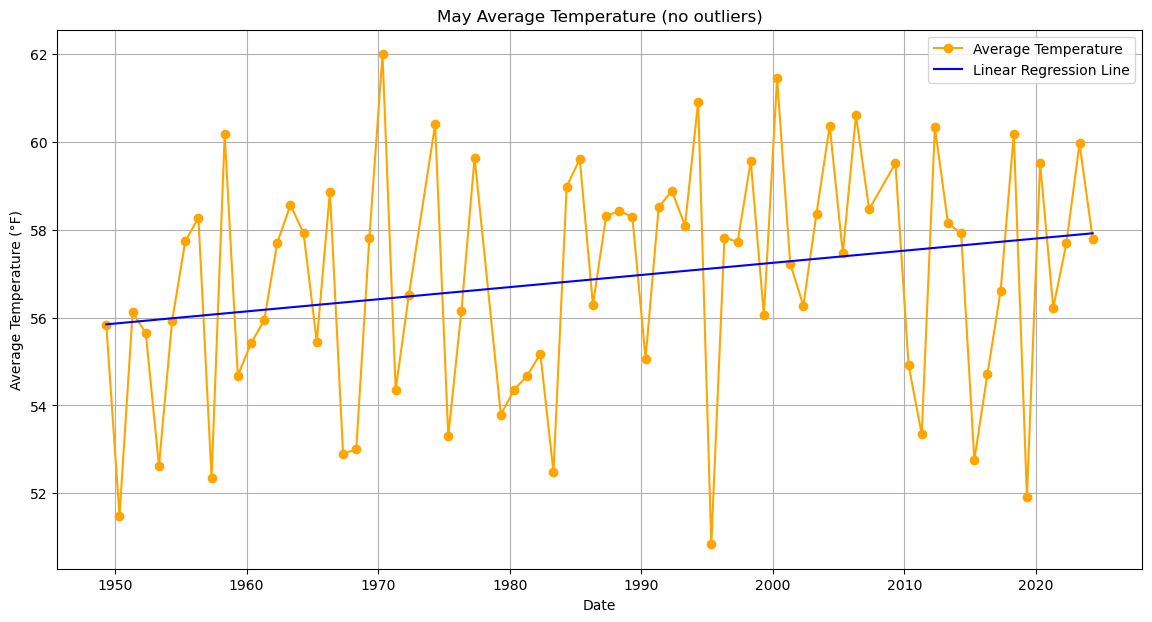

Slope: 0.00007572 days/year
R-squared: 0.05448614
P-value: 0.04686817
Standard Error: 0.00003743 days/year


In [81]:
months_to_include = [5]  # Adjust this list as needed
filtered_data = data_with_avg[data_with_avg['month'].isin(months_to_include)]

# Calculate the average temperature for each month
monthly_avg_temp = filtered_data.groupby('month_start')['average_temp'].mean().reset_index()

# Remove outliers using IQR
Q1 = monthly_avg_temp['average_temp'].quantile(0.25)
Q3 = monthly_avg_temp['average_temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_monthly_avg_temp = monthly_avg_temp[
    (monthly_avg_temp['average_temp'] >= lower_bound) &
    (monthly_avg_temp['average_temp'] <= upper_bound)
]

# Linear regression on the filtered data
filtered_monthly_avg_temp['month_ordinal'] = filtered_monthly_avg_temp['month_start'].map(pd.Timestamp.toordinal)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_monthly_avg_temp['month_ordinal'], filtered_monthly_avg_temp['average_temp']
)

regression_line = intercept + slope * filtered_monthly_avg_temp['month_ordinal']

# Plot
#plt.figure(figsize=(15, 7))
plt.plot(filtered_monthly_avg_temp['month_start'], filtered_monthly_avg_temp['average_temp'], color='orange', marker='o', label='Average Temperature')
plt.plot(filtered_monthly_avg_temp['month_start'], regression_line, color='blue', label='Linear Regression Line')
plt.title(f"May Average Temperature (no outliers)")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.savefig('plots/fortcollins/may_temp.png', bbox_inches='tight')
plt.show()

print(f"Slope: {slope:.8f} days/year")
print(f"R-squared: {r_value**2:.8f}")
print(f"P-value: {p_value:.8f}")
print(f"Standard Error: {std_err:.8f} days/year")


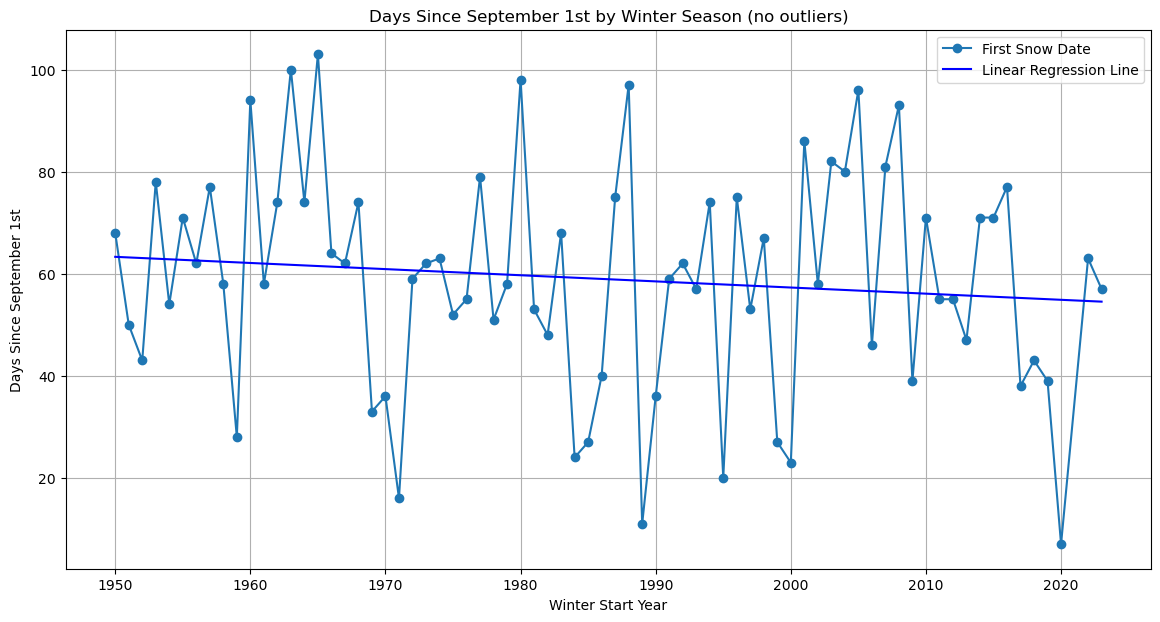

Slope: -0.12028357 days/year
Intercept: 297.859062 days
R-squared: 0.01354609
P-value: 0.32679454
Standard Error: 0.12181719 days/year


In [82]:
# Define inches for "first snow" threshold
first_snow_threshold = 1 #inch

first_snow_dates = []
for start_year in range(1950, 2024):
    winter_start = pd.Timestamp(f'{start_year}-09-01')
    winter_end = pd.Timestamp(f'{start_year + 1}-05-31')

    # Filter data for just the winter season
    winter_data = data[(data['date'] >= winter_start) & (data['date'] <= winter_end)]

    # Get days with snow greater than the threshold
    snow_days = winter_data[winter_data['snow'] >= first_snow_threshold]# | (winter_data['snow'] > first_snow_threshold)]

    first_snow_date = snow_days['date'].min()
    first_snow_dates.append({
        'winter_start_year': start_year,
        'first_snow_date': first_snow_date
    })
    
# Convert to DataFrame
first_snow_df = pd.DataFrame(first_snow_dates)

# Drop seasons without a first snow date
first_snow_df = first_snow_df.dropna(subset=['first_snow_date'])

# Calculate the number of days since September 1st for each first snow date
first_snow_df['days_since_sept1'] = (
    first_snow_df['first_snow_date'] -
    pd.to_datetime(first_snow_df['winter_start_year'].astype(str) + '-09-01')
).dt.days

# Remove outliers using the IQR
Q1 = first_snow_df['days_since_sept1'].quantile(0.25)
Q3 = first_snow_df['days_since_sept1'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_snow_df = first_snow_df[
    (first_snow_df['days_since_sept1'] >= lower_bound) &
    (first_snow_df['days_since_sept1'] <= upper_bound)
]

# Plot
#plt.figure(figsize=(12, 6))
plt.plot(
    filtered_snow_df['winter_start_year'],
    filtered_snow_df['days_since_sept1'],
    label='First Snow Date',
    marker='o'
)
plt.title("Days Since September 1st by Winter Season (no outliers)")
plt.xlabel("Winter Start Year")
plt.ylabel("Days Since September 1st")
plt.grid(True)

# Perform linear regression on the filtered data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_snow_df['winter_start_year'],
    filtered_snow_df['days_since_sept1']
)

# Create regression line values
regression_line = intercept + slope * filtered_snow_df['winter_start_year']

# Plot the regression line
plt.plot(
    filtered_snow_df['winter_start_year'],
    regression_line,
    color='blue',
    label='Linear Regression Line'
)

plt.legend()
plt.savefig('plots/fortcollins/first_snow_by_season.png', bbox_inches='tight')
plt.show()

# Optionally, print regression statistics
print(f"Slope: {slope:.8f} days/year")
print(f"Intercept: {intercept:.6f} days")
print(f"R-squared: {r_value**2:.8f}")
print(f"P-value: {p_value:.8f}")
print(f"Standard Error: {std_err:.8f} days/year")


P-value is very very high, so we can't reject the null hypothesis. With standard error so high the true slope could be positive, the linear regression line is not reliable at all.

In [83]:
# Code used from XCast documentation examples
from sklearn.model_selection import TimeSeriesSplit
import xcast as xc
from xcast.verification import (
    index_of_agreement,
    kling_gupta_efficiency,
    normalized_centered_root_mean_squared_error,
)

# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Create lag features
data['snowcover_yesterday'] = data['snowcover'].shift(1)
data['snow_yesterday'] = data['snow'].shift(1)

# Drop NaN values resulting from lag features
data.dropna(subset=['snowcover_yesterday', 'snow_yesterday'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Set train / test
winter_2023_start = '2023-09-01'
winter_2023_end = '2024-05-31'
train_data = data[data['date'] < winter_2023_start].copy()
test_data = data[(data['date'] >= winter_2023_start) & (data['date'] <= winter_2023_end)].copy()

# x is the input features (predictors), y is the target
x_train = train_data[['tmax', 'tmin', 'precip', 'snowcover_yesterday', 'snow_yesterday']].values
y_train = train_data['snow'].values.reshape(-1, 1)
x_test = test_data[['tmax', 'tmin', 'precip', 'snowcover_yesterday', 'snow_yesterday']].values
y_test = test_data['snow'].values.reshape(-1, 1)

In [84]:
# Define ELM parameters
elm_kwargs = {
  'regularization': 10,
  'hidden_layer_size': 10,#5
  'activation': 'relu',#, 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
  'preprocessing':'minmax',# 'preprocessing': ['minmax', 'std', 'none' ],
  #'encoding': 'nonexceedance',#'encoding': [  'nonexceedance', 'binary'],
  #'quantiles': [1/3,2/3], #[0.0001, 0.5, 0.9999], [0.2, 0.4, 0.6, 0.8], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] ],
  #'standardize_y': True,#'standardize_y': [True, False],
  'n_estimators': 100,#30
  #'initialization':'normal'# ['uniform', 'normal', 'xavier']
}

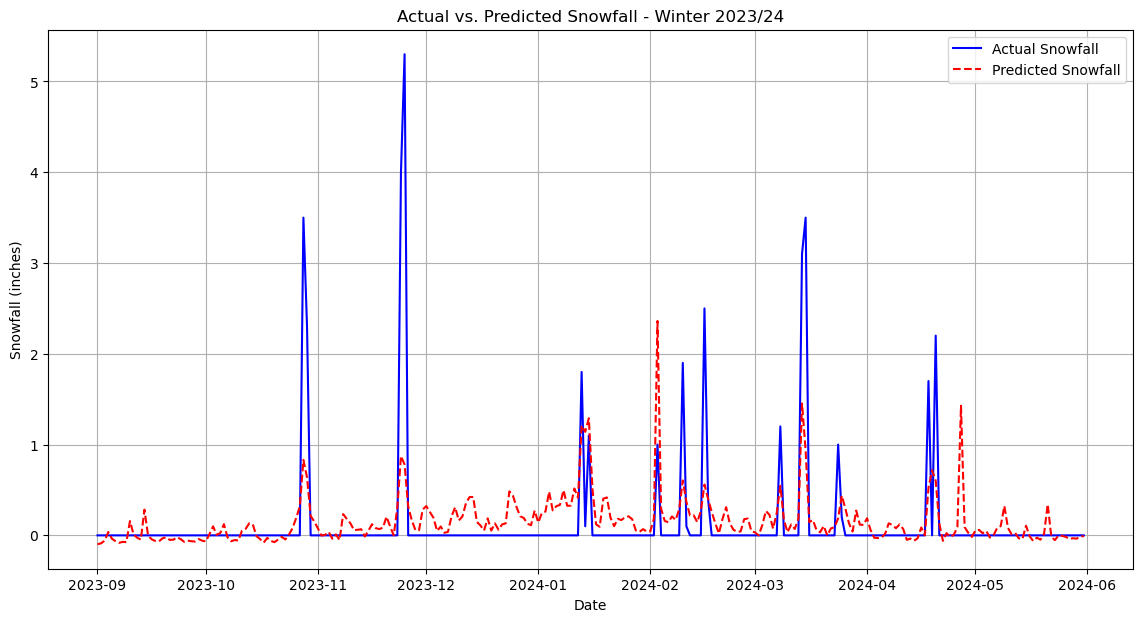

ELM Evaluation for Winter 2023/24:
CC: 0.56176560
IOA: 0.60284306
KGE: 0.07133943
NCRMSE: 3.82703553


In [85]:
# Train the ELM model
elm = xc.extreme_learning_machine(**elm_kwargs)
elm.fit(x_train, y_train)

# Predict snowfall on test data (Winter 2023/24)
predictions = elm.predict(x_test)

# Prepare the results for plotting
results_df = test_data[['date']].copy()
results_df['Actual Snowfall'] = y_test
results_df['Predicted Snowfall'] = predictions

# Plot the actual vs. predicted snowfall
#plt.figure(figsize=(8, 5))
plt.plot(results_df['date'], results_df['Actual Snowfall'], label='Actual Snowfall', color='blue')
plt.plot(results_df['date'], results_df['Predicted Snowfall'], label='Predicted Snowfall', color='red', linestyle='--')
plt.title('Actual vs. Predicted Snowfall - Winter 2023/24')
plt.xlabel('Date')
plt.ylabel('Snowfall (inches)')
plt.legend()
plt.grid(True)
plt.savefig('plots/fortcollins/actual_vs_predicted_snowfall.png', bbox_inches='tight')
plt.show()

# Evaluate the model performance on Winter 2023/24
cc_test = stats.pearsonr(predictions.squeeze(), y_test.squeeze())[0]
ioa_test = index_of_agreement(predictions, y_test)
kge_test = kling_gupta_efficiency(predictions, y_test)
ncrmse_test = normalized_centered_root_mean_squared_error(predictions, y_test)
print('ELM Evaluation for Winter 2023/24:')
print(f'CC: {cc_test:.8f}')
print(f'IOA: {ioa_test:.8f}')
print(f'KGE: {kge_test:.8f}')
print(f'NCRMSE: {ncrmse_test:.8f}')


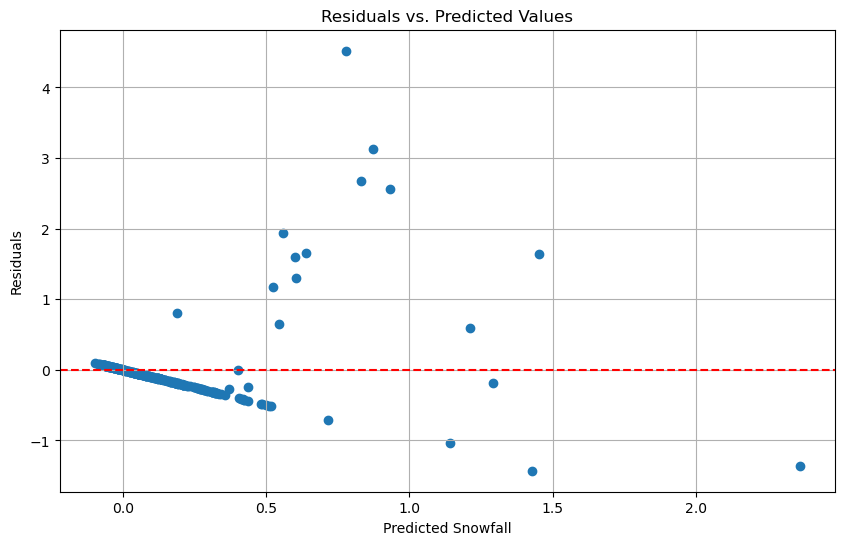

In [86]:
residuals = y_test.squeeze() - predictions.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Snowfall')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()


CC (Correlation Coefficient):
- +1 indicates a perfect positive linear relationship.
- 0 indicates no linear relationship.
- -1 indicates a perfect negative linear relationship.

IOA (Index of Agreement):
- 1 indicates perfect agreement between the model and observations.
- 0 indicates no agreement at all.

KGE (Kling-Gupta Efficiency):
- 1 indicates perfect agreement/model performance.
- Negative values indicate worse performance than using the mean of the observed data as a predictor.

NCRMSE (Normalized Root Mean Square Error):
- 0 indicates perfect prediction.
- Higher values indicate greater error relative to the observed data's scale.

In [87]:
# Time series Cross-Validation on the training data
time_series_cv = TimeSeriesSplit(n_splits=24)

xval_preds, xval_y = [], []

for train_idx, val_idx in time_series_cv.split(x_train):
    xtrain_cv, ytrain_cv = x_train[train_idx], y_train[train_idx]
    xval_cv, yval_cv = x_train[val_idx], y_train[val_idx]
    
    xval_y.append(yval_cv)
    
    # Initialize and train the ELM model
    elm_cv = xc.extreme_learning_machine(**elm_kwargs)
    elm_cv.fit(xtrain_cv, ytrain_cv)
    
    # Predict on validation set
    preds_cv = elm_cv.predict(xval_cv)
    xval_preds.append(preds_cv)

# Concatenate predictions and true values from cross-validation
preds_cv = np.vstack(xval_preds)
true_values_cv = np.vstack(xval_y)

# Evaluate cross-validation performance
cc_cv = stats.pearsonr(preds_cv.squeeze(), true_values_cv.squeeze())[0]
ioa_cv = index_of_agreement(preds_cv, true_values_cv)
kge_cv = kling_gupta_efficiency(preds_cv, true_values_cv)
ncrmse_cv = normalized_centered_root_mean_squared_error(preds_cv, true_values_cv)

print('ELM Cross-Validation Evaluation on Training Data:')
print(f'CC: {cc_cv:.8f}')
print(f'IOA: {ioa_cv:.8f}')
print(f'KGE: {kge_cv:.8f}')
print(f'NCRMSE: {ncrmse_cv:.8f}')
print('---')

ELM Cross-Validation Evaluation on Training Data:
CC: 0.51952371
IOA: 0.45655715
KGE: -0.04154089
NCRMSE: 5.15925866
---
